In [379]:
import random
import numpy as np 
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

pd.set_option('display.max_columns', 35)
pd.set_option('display.max_rows', 25)

import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\14708\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [339]:
main_df = pd.read_csv(r"C:\Users\14708\Downloads\Tata and Hyundai cars - data.xlsx - Data.csv")
df = main_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1528 non-null   object 
 1   Headline              710 non-null    object 
 2   URL                   1528 non-null   object 
 3   Opening Text          710 non-null    object 
 4   Hit Sentence          1528 non-null   object 
 5   Source                1528 non-null   object 
 6   Influencer            1065 non-null   object 
 7   Country               1528 non-null   object 
 8   Subregion             321 non-null    object 
 9   Language              1528 non-null   object 
 10  Reach                 1519 non-null   float64
 11  Desktop Reach         710 non-null    float64
 12  Mobile Reach          710 non-null    float64
 13  Twitter Social Echo   710 non-null    float64
 14  Facebook Social Echo  710 non-null    float64
 15  Reddit Social Echo   

In [340]:
df.isna().sum()

Date                       0
Headline                 818
URL                        0
Opening Text             818
Hit Sentence               0
Source                     0
Influencer               463
Country                    0
Subregion               1207
Language                   0
Reach                      9
Desktop Reach            818
Mobile Reach             818
Twitter Social Echo      818
Facebook Social Echo     818
Reddit Social Echo       818
National Viewership        0
Engagement              1176
Sentiment                  0
Keywords                   0
State                    500
dtype: int64

In [341]:
print('Subregion:',df['Subregion'].isna().sum())
print('State:',df['State'].isna().sum())

Subregion: 1207
State: 500


In [342]:
''' Most of the values in Subregion are State names and with their high null value content, it is better to use Subregion 
    to fill any null values in the State column and then decompose the column'''
print('State: ',df['State'].fillna(df['Subregion']).isna().sum())
print('Subregion: ',df['Subregion'].fillna(df['State']).isna().sum())

# it will be better to remove the subregion column 
df.drop(columns='Subregion', inplace=True)

State:  497
Subregion:  497


In [343]:
# The Reach column has only 9 null values so it's better to remove those 9 rows.
df.dropna(subset='Reach', inplace=True)

In [344]:
# It also makes no sense to keep the engagement column
df.drop(columns=['Engagement'], inplace=True)

In [345]:
# Renaming the Keyword column as Parameters
df['label'] = df['Keywords']
df.drop(columns='Keywords', inplace=True)

In [346]:
''' On comparision it seems that some columns have high null values only because of the source twitter,
    So it is better to have 2 different datasets to analyze the data without any data loss'''
print('Twitter null values:')
df[df['Source']=='Twitter'].isna().sum()

Twitter null values:


Date                      0
Headline                809
URL                       0
Opening Text            809
Hit Sentence              0
Source                    0
Influencer                0
Country                   0
Language                  0
Reach                     0
Desktop Reach           809
Mobile Reach            809
Twitter Social Echo     809
Facebook Social Echo    809
Reddit Social Echo      809
National Viewership       0
Sentiment                 0
State                   126
label                     0
dtype: int64

In [347]:
print('National Viewership: ',df['National Viewership'].value_counts())
# Again makes no sense to keep national viewership, so will remove this column too
df.drop(columns='National Viewership', inplace=True)

National Viewership:  National Viewership
0    1519
Name: count, dtype: int64


In [348]:
print(df['Date'].min()), print(df['Date'].max())  # Seems like all the posts are in Septemeber of 2023, thus will create day and hour column

df['Date'] = pd.to_datetime(df['Date']) 
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour

C:\Users\14708\AppData\Local\Temp\ipykernel_25000\3896510544.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


12-Sep-2023 01:04PM
28-Sep-2023 12:49PM


In [349]:
df['label'].unique() # Checking for unique labels
df['label']=df['label'].str.lower()  

df['label'].unique() # In order to reduce the redundance, i plan to create 3 labels - tata, hyundai, tata_hyundai

label_keywords = {
    'hyundai,cars':'hyundai', 'tata,cars':'tata', 'cars,tata':'tata', 'hyundai,cars,hyundai':'hyundai',
       'cars,hyundai':'hyundai', 'hyundai,cars,cars':'hyundai', 'cars,tata,hyundai':'hyundai',
       'cars,hyundai,tata':'tata_hyundai', 'tata,cars,tata':'tata', 'cars,cars,tata':'tata',
       'cars,hyundai,cars':'hyundai', 'cars,hyundai,cars,tata':'tata_hyundai', 'tata,cars,hyundai':'tata_hyundai',
       'tata,cars,cars':'tata', 'cars,tata,tata,hyundai':'tata_hyundai',
       'hyundai,cars,tata,cars':'tata_hyundai', 'tata,tata,cars':'tata', 'tata,cars,tata,cars':'tata',
       'hyundai,cars,tata':'tata_hyundai', 'hyundai,tata,cars':'tata_hyundai', 'cars,cars,tata,tata':'tata',
       'cars,tata,tata':'tata', 'cars,tata,hyundai,cars':'tata_hyundai', 'cars,tata,cars':'tata',
       'tata,cars,hyundai,cars':'tata_hyundai', 'tata,hyundai,cars':'tata_hyundai',
       'cars,hyundai,hyundai,cars':'hyundai', 'cars,tata,cars,hyundai':'tata_hyundai'
}

df['label'] = df['label'].map(label_keywords)
df['label'].unique()

array(['hyundai', 'tata', 'tata_hyundai'], dtype=object)

In [350]:
df # this is the absolute dataset.
twitter_df=df[df['Source']=='Twitter']
remaining_df = df[df['Source']!='Twitter']

------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Twitter Dataset (dealing with missing values)

In [351]:
# Checking and dealing with null vlaues in twitter_df
twitter_df.isna().sum()
# it is wise to remove the columns with high null values
twitter_df.drop(columns=[
    'Headline', 'Opening Text', 'Desktop Reach', 'Mobile Reach', 'Twitter Social Echo', 'Facebook Social Echo', 'Reddit Social Echo'
                         ], inplace=True)

twitter_df.isna().sum()

C:\Users\14708\AppData\Local\Temp\ipykernel_25000\3111735953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df.drop(columns=[


Date              0
URL               0
Hit Sentence      0
Source            0
Influencer        0
Country           0
Language          0
Reach             0
Sentiment         0
State           126
label             0
day               0
hour              0
dtype: int64

In [352]:
# I aim to fill the null values in the state column as per the value count ration of the non null values
print(twitter_df['State'].value_counts())

def fill_na_based_on_ratio(df, column_name):
    value_counts = df[column_name].value_counts()
    total_counts = value_counts.sum()
    null_count = df[column_name].isnull().sum()
    ratio = value_counts / total_counts
    fill_values = ratio.index.to_list()
    fill_probabilities = ratio.to_list()

    df[column_name] = df[column_name].apply(
        lambda x: np.random.choice(fill_values, p=fill_probabilities) if pd.isnull(x) else x
    )

# Fill null values in twitter_df
for column in twitter_df.columns:
    fill_na_based_on_ratio(twitter_df, column)

State
Tamil Nadu          247
Maharashtra         110
Karnataka            64
Delhi                46
Kerala               36
                   ... 
Uttarakhand           1
Tripura               1
Goa                   1
Mizoram               1
Himachal Pradesh      1
Name: count, Length: 28, dtype: int64


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\2978578175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(
C:\Users\14708\AppData\Local\Temp\ipykernel_25000\2978578175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(
C:\Users\14708\AppData\Local\Temp\ipykernel_25000\2978578175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

#### Remaining Dataset (Dealing with missing Values)

In [353]:
remaining_df.isna().sum()

Date                      0
Headline                  0
URL                       0
Opening Text              0
Hit Sentence              0
Source                    0
Influencer              463
Country                   0
Language                  0
Reach                     0
Desktop Reach             0
Mobile Reach              0
Twitter Social Echo       0
Facebook Social Echo      0
Reddit Social Echo        0
Sentiment                 0
State                   371
label                     0
day                       0
hour                      0
dtype: int64

In [354]:
# it makes sense to remove the Influence and State column in this dataset
remaining_df.drop(columns=['Influencer', 'State'], inplace=True)

C:\Users\14708\AppData\Local\Temp\ipykernel_25000\1376430963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remaining_df.drop(columns=['Influencer', 'State'], inplace=True)


In [355]:
remaining_df

,Date,Headline,URL,Opening Text,Hit Sentence,Source,Country,Language,Reach,Desktop Reach,Mobile Reach,Twitter Social Echo,Facebook Social Echo,Reddit Social Echo,Sentiment,label,day,hour
0,2023-09-28 14:08:00,Kia और Hyundai ने वापस बुलाईं अपनी 35 लाख कारे...,https://hindi.pardaphash.com/kia-and-hyundai-r...,Kia and Hyundai Recalled Cars: वाहन निर्माता क...,Kia and Hyundai Recalled Cars: वाहन निर्माता क...,Pardaphash,India,Hindi,31307.0,1279.0,30028.0,0.0,0.0,0.0,Neutral,hyundai,28,14
1,2023-09-28 13:46:00,"Tata Punch EV spied, may compete with MG Comen...",https://economictimes.indiatimes.com/industry/...,Tata Motors is reportedly developing an electr...,... Punch EV is expected to compete with the M...,The Economic Times,India,English,15403059.0,6171732.0,9231327.0,0.0,0.0,0.0,Neutral,tata,28,13
2,2023-09-28 13:30:00,Tata Avinya Reviews On Road Price 2023 Mileage...,https://badisoch.in/automobile-news/tata-aviny...,... (adsbygoogle = window.adsbygoogle || []).p...,"... , despite most carmakers focusing on large...",Badi Soch,India,English,1128280.0,171549.0,956731.0,0.0,0.0,0.0,Neutral,tata,28,13
5,2023-09-28 12:49:00,Oldest Indian Companies and Their Current Acti...,https://www.businessoutreach.in/oldest-indian-...,"India’s rich еntrеprеnеurial history, dating b...",... on thе intеrnational stagе. Innovation and...,Business Outreach,India,English,71485.0,9301.0,62184.0,0.0,0.0,0.0,Positive,tata,28,12
6,2023-09-28 12:25:00,Maruti Suzuki Swift vs Tata Altroz: Comparing ...,https://nationalcybersecurity.com/maruti-suzuk...,"For a safety-conscious buyer, it is important ...","... to consider the safest cars, or top safety...",National Cyber Security,India,English,817.0,428.0,389.0,0.0,0.0,0.0,Positive,tata,28,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,2023-09-12 06:36:00,MG3 hatchback takes out ‘cheapest car to run’ ...,https://planetcirculate.com/mg3-hatchback-take...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",Planet Circulate,India,English,1142.0,1142.0,0.0,0.0,0.0,0.0,Positive,hyundai,12,6
1523,2023-09-12 06:20:00,MG3 hatchback takes out ‘cheapest car to run’ ...,https://bulletinreporter.com/mg3-hatchback-tak...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",Bulletin Reporter,India,English,2074.0,2074.0,0.0,0.0,0.0,0.0,Positive,hyundai,12,6
1524,2023-09-12 05:24:00,MG3 hatchback named by RACV as the most cost-e...,https://vervetimes.com/mg3-hatchback-named-by-...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",Verve times - Latest News around the World,India,English,26425.0,7491.0,18934.0,0.0,0.0,0.0,Positive,hyundai,12,5
1525,2023-09-12 04:37:00,RACV names MG3 hatchback as the cheapest vehic...,https://newsconcerns.com/racv-names-mg3-hatchb...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",News Concerns - Latest News Update,India,English,9323.0,2527.0,6796.0,0.0,0.0,0.0,Positive,hyundai,12,4


In [356]:
# twitter data file
twitter_df.to_csv('twitter_data.csv', index=False)
# Remaining data file
remaining_df.to_csv('remaining_df.csv', index=False)

------------------------------------------------------------------------------------------------------------------------------------------------------------

## Entire Dataset

In [357]:
df.columns

Index(['Date', 'Headline', 'URL', 'Opening Text', 'Hit Sentence', 'Source',
       'Influencer', 'Country', 'Language', 'Reach', 'Desktop Reach',
       'Mobile Reach', 'Twitter Social Echo', 'Facebook Social Echo',
       'Reddit Social Echo', 'Sentiment', 'State', 'label', 'day', 'hour'],
      dtype='object')

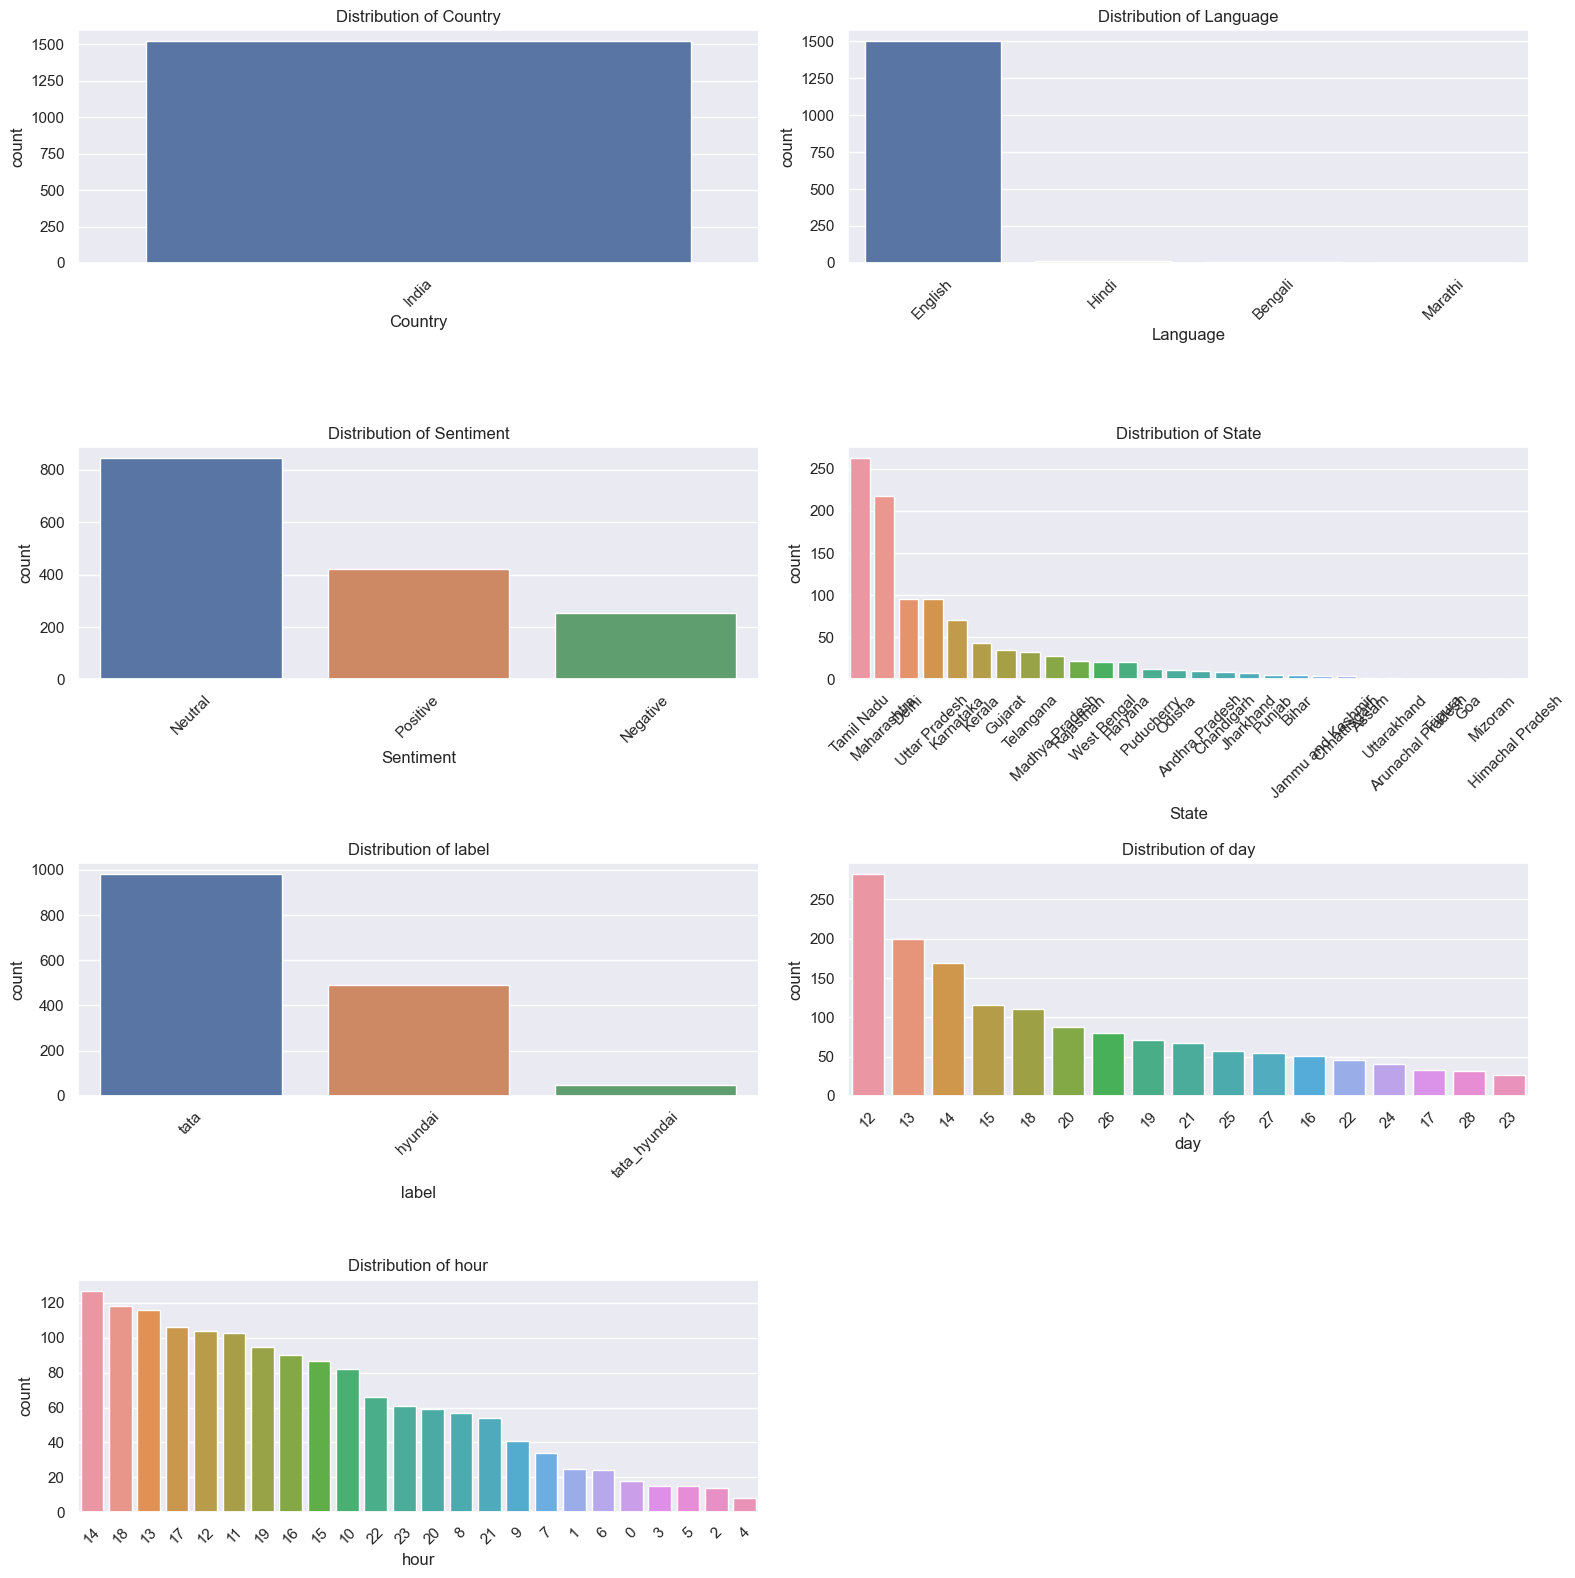

In [358]:
def plot_categorical_distribution(dataframe):
    categorical_columns = ['Country', 'Language', 'Sentiment', 'State', 'label', 'day', 'hour']
    
    num_cols = len(categorical_columns)
    num_rows = (num_cols + 1) // 2

    # Increase the width of subplots by modifying the figsize parameter
    fig, axes = plt.subplots(num_rows, 2, figsize=(16, num_rows * 4))

    if num_rows == 1:
        axes = axes.flatten()
    
    for i, column in enumerate(categorical_columns):
        row, col = divmod(i, 2)
        
        ax = axes[row, col]  # Access the specific subplot in the grid
        ax.set_title(f'Distribution of {column}')
        sns.countplot(data=dataframe, x=column, order=dataframe[column].value_counts().index, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    for i in range(num_cols, num_rows * 2):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

plot_categorical_distribution(df)

In [359]:
sentiment_keywords = {'Neutral':0, 'Negative':-1, 'Positive':1}
df['sentiment_score'] = df['Sentiment'].map(sentiment_keywords)

In [360]:
def map_sentiment_score_to_label(sentiment_score):
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis based on 'Sentiment Score' column
df['Sentiment Analysis'] = df['sentiment_score'].apply(map_sentiment_score_to_label)

df

,Date,Headline,URL,Opening Text,Hit Sentence,Source,Influencer,Country,Language,Reach,Desktop Reach,Mobile Reach,Twitter Social Echo,Facebook Social Echo,Reddit Social Echo,Sentiment,State,label,day,hour,sentiment_score,Sentiment Analysis
0,2023-09-28 14:08:00,Kia और Hyundai ने वापस बुलाईं अपनी 35 लाख कारे...,https://hindi.pardaphash.com/kia-and-hyundai-r...,Kia and Hyundai Recalled Cars: वाहन निर्माता क...,Kia and Hyundai Recalled Cars: वाहन निर्माता क...,Pardaphash,NaN,India,Hindi,31307.0,1279.0,30028.0,0.0,0.0,0.0,Neutral,Delhi,hyundai,28,14,0,Neutral
1,2023-09-28 13:46:00,"Tata Punch EV spied, may compete with MG Comen...",https://economictimes.indiatimes.com/industry/...,Tata Motors is reportedly developing an electr...,... Punch EV is expected to compete with the M...,The Economic Times,NaN,India,English,15403059.0,6171732.0,9231327.0,0.0,0.0,0.0,Neutral,Maharashtra,tata,28,13,0,Neutral
2,2023-09-28 13:30:00,Tata Avinya Reviews On Road Price 2023 Mileage...,https://badisoch.in/automobile-news/tata-aviny...,... (adsbygoogle = window.adsbygoogle || []).p...,"... , despite most carmakers focusing on large...",Badi Soch,NaN,India,English,1128280.0,171549.0,956731.0,0.0,0.0,0.0,Neutral,NaN,tata,28,13,0,Neutral
3,2023-09-28 13:24:00,NaN,http://twitter.com/automobilindia8/statuses/17...,NaN,Engine Fire-Related Risks Force Kia & Hyundai ...,Twitter,@automobilindia8,India,English,2.0,NaN,NaN,NaN,NaN,NaN,Neutral,Karnataka,hyundai,28,13,0,Neutral
4,2023-09-28 13:22:00,NaN,http://twitter.com/MalakpetD/statuses/17073021...,NaN,"@srinualavilli @BMTC_BENGALURU Mahindra, Tata,...",Twitter,@MalakpetD,India,English,506.0,NaN,NaN,NaN,NaN,NaN,Neutral,Telangana,tata,28,13,0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,2023-09-12 06:20:00,MG3 hatchback takes out ‘cheapest car to run’ ...,https://bulletinreporter.com/mg3-hatchback-tak...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",Bulletin Reporter,Kemal Pasha,India,English,2074.0,2074.0,0.0,0.0,0.0,0.0,Positive,NaN,hyundai,12,6,1,Positive
1524,2023-09-12 05:24:00,MG3 hatchback named by RACV as the most cost-e...,https://vervetimes.com/mg3-hatchback-named-by-...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",Verve times - Latest News around the World,NaN,India,English,26425.0,7491.0,18934.0,0.0,0.0,0.0,Positive,NaN,hyundai,12,5,1,Positive
1525,2023-09-12 04:37:00,RACV names MG3 hatchback as the cheapest vehic...,https://newsconcerns.com/racv-names-mg3-hatchb...,A small car has claimed the title of the cheap...,"... Costs Survey, which lists the cost of runn...",News Concerns - Latest News Update,Charlie Brown,India,English,9323.0,2527.0,6796.0,0.0,0.0,0.0,Positive,Madhya Pradesh,hyundai,12,4,1,Positive
1526,2023-09-12 04:04:00,Tata Power EZ App Electrifies Green Revolution...,https://thenfapost.com/tata-power-ez-app-elect...,Tata Power EZ App Electrifies Green Revolution...,Charging hubs for leading cab fleet operators....,NFAPost,N V Vijayakumar,India,English,851.0,851.0,0.0,0.0,0.0,0.0,Neutral,Karnataka,tata,12,4,0,Neutral


In [361]:
# Cleaning Hit Sentence Column

# Converting it to Lowercase
df['Hit Sentence']= df['Hit Sentence'].str.lower()
# Removing Punctuations 
df['Hit Sentence']=df['Hit Sentence'].str.translate(str.maketrans('','',string.punctuation))

In [362]:
hyundai_data = df[df['label'] == 'hyundai']
tata_data = df[df['label'] == 'tata']
tata_hyundai_data = df[df['label'] == 'tata_hyundai']

C:\Users\14708\AppData\Local\Temp\ipykernel_25000\3042022419.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x='sentiment_score', bins=20, kde=True, ax=ax1, palette='viridis')


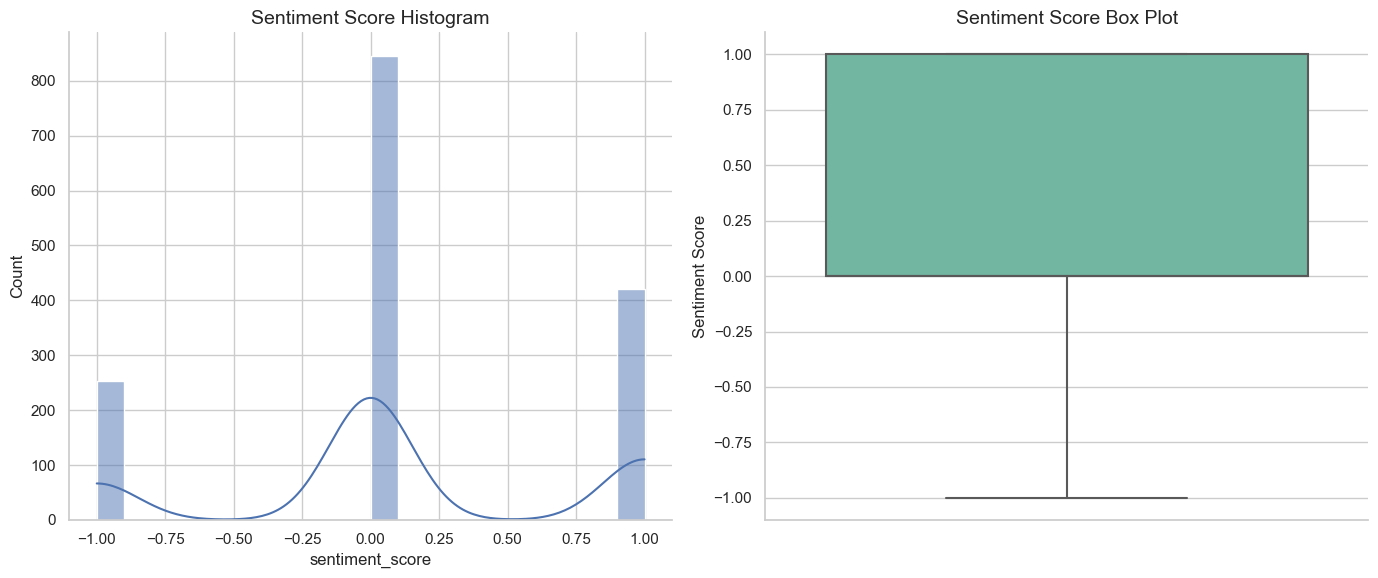

In [363]:
# Creating a figure with subplots
sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df, x='sentiment_score', bins=20, kde=True, ax=ax1, palette='viridis')
ax1.set_title('Sentiment Score Histogram', fontsize=14)

sns.boxplot(data=df, y='sentiment_score', ax=ax2, palette='Set2')
ax2.set_title('Sentiment Score Box Plot', fontsize=14)

ax2.set(ylabel='Sentiment Score')

sns.despine()

plt.tight_layout()
plt.show()

In [364]:
# Summary statistics for 'Sentiment Score' column
sentiment_score_stats = df['sentiment_score'].describe()

# Distribution of 'Sentiment Score'
sentiment_score_distribution = df['sentiment_score'].value_counts()

# Mean sentiment score
mean_sentiment_score = df['sentiment_score'].mean()

# Median sentiment score
median_sentiment_score = df['sentiment_score'].median()

print("Summary Statistics for 'Sentiment Score':")
print(sentiment_score_stats)

print("\nDistribution of 'Sentiment Score':")
print(sentiment_score_distribution)

print(f"\nMean Sentiment Score: {mean_sentiment_score}")
print(f"Median Sentiment Score: {median_sentiment_score}")

Summary Statistics for 'Sentiment Score':
count    1519.000000
mean        0.109941
std         0.656697
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: sentiment_score, dtype: float64

Distribution of 'Sentiment Score':
sentiment_score
 0    846
 1    420
-1    253
Name: count, dtype: int64

Mean Sentiment Score: 0.10994075049374588
Median Sentiment Score: 0.0


## Consumer Perception

### Tata

In [365]:
average_sentiment_score = tata_data['sentiment_score'].mean()

def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

tata_data['Sentiment Category'] = tata_data['sentiment_score'].apply(categorize_sentiment)

average_reach = tata_data['Reach'].mean()

sentiment_counts = tata_data['Sentiment Category'].value_counts()

# Calculate the percentage of each sentiment category
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

print(f"Average Sentiment Score for Tata cars: {average_sentiment_score:.2f}")
print(f"Average Reach for Tata cars: {average_reach:.2f}")
print("\nSentiment Category Counts:")
print(sentiment_counts)
print("\nSentiment Category Percentages:")
print(sentiment_percentages)

Average Sentiment Score for Tata cars: 0.10
Average Reach for Tata cars: 2179684.99

Sentiment Category Counts:
Sentiment Category
Neutral     626
Positive    227
Negative    127
Name: count, dtype: int64

Sentiment Category Percentages:
Sentiment Category
Neutral     63.877551
Positive    23.163265
Negative    12.959184
Name: count, dtype: float64


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\3291404411.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tata_data['Sentiment Category'] = tata_data['sentiment_score'].apply(categorize_sentiment)


In [366]:
def categorize_attribute(sentence):
    if any(keyword in sentence.lower() for keyword in ['safety', 'secure', 'crash', 'protection']):
        return 'Safety'
    elif any(keyword in sentence.lower() for keyword in ['fuel efficiency', 'mileage', 'mpg', 'consumption']):
        return 'Fuel Efficiency'
    elif any(keyword in sentence.lower() for keyword in ['accessories', 'features', 'interior', 'technology']):
        return 'Accessories'
    elif any(keyword in sentence.lower() for keyword in ['electric vehicle', 'ev', 'battery', 'charging']):
        return 'EV'
    elif any(keyword in sentence.lower() for keyword in ['performance', 'speed', 'acceleration', 'horsepower']):
        return 'Performance'
    elif any(keyword in sentence.lower() for keyword in ['cost', 'price', 'affordable', 'expensive']):
        return 'Cost'
    else:
        return 'Other'

tata_data['Attribute'] = tata_data['Hit Sentence'].apply(categorize_attribute)

average_sentiment = tata_data.groupby('Attribute').agg({'sentiment_score': 'mean', 'Reach': 'sum'}).reset_index()

print(average_sentiment)


         Attribute  sentiment_score         Reach
0      Accessories         0.368421  7.423338e+07
1             Cost         0.472222  2.485890e+08
2               EV        -0.019380  6.602274e+08
3  Fuel Efficiency         0.666667  1.265916e+07
4            Other         0.125796  1.132056e+09
5      Performance        -0.500000  2.706400e+04
6           Safety        -0.032258  8.298788e+06


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\2669460840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tata_data['Attribute'] = tata_data['Hit Sentence'].apply(categorize_attribute)


## Hyundai

In [367]:
average_sentiment_score_hyundai = hyundai_data['sentiment_score'].mean()

def categorize_sentiment_hyundai(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

hyundai_data['Sentiment Category'] = hyundai_data['sentiment_score'].apply(categorize_sentiment_hyundai)

average_reach_hyundai = hyundai_data['Reach'].mean()

sentiment_counts_hyundai = hyundai_data['Sentiment Category'].value_counts()

# Calculate the percentage of each sentiment category for Hyundai
sentiment_percentages_hyundai = (sentiment_counts_hyundai / sentiment_counts_hyundai.sum()) * 100

print(f"Average Sentiment Score for Hyundai cars: {average_sentiment_score_hyundai:.2f}")
print(f"Average Reach for Hyundai cars: {average_reach_hyundai:.2f}")
print("\nSentiment Category Counts for Hyundai:")
print(sentiment_counts_hyundai)
print("\nSentiment Category Percentages for Hyundai:")
print(sentiment_percentages_hyundai)

Average Sentiment Score for Hyundai cars: 0.10
Average Reach for Hyundai cars: 3735315.52

Sentiment Category Counts for Hyundai:
Sentiment Category
Neutral     196
Positive    172
Negative    122
Name: count, dtype: int64

Sentiment Category Percentages for Hyundai:
Sentiment Category
Neutral     40.000000
Positive    35.102041
Negative    24.897959
Name: count, dtype: float64


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\1272697996.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyundai_data['Sentiment Category'] = hyundai_data['sentiment_score'].apply(categorize_sentiment_hyundai)


In [368]:
def categorize_attribute(sentence):
    if any(keyword in sentence.lower() for keyword in ['safety', 'secure', 'crash', 'protection']):
        return 'Safety'
    elif any(keyword in sentence.lower() for keyword in ['fuel efficiency', 'mileage', 'mpg', 'consumption']):
        return 'Fuel Efficiency'
    elif any(keyword in sentence.lower() for keyword in ['accessories', 'features', 'interior', 'technology']):
        return 'Accessories'
    elif any(keyword in sentence.lower() for keyword in ['electric vehicle', 'ev', 'battery', 'charging']):
        return 'EV'
    elif any(keyword in sentence.lower() for keyword in ['performance', 'speed', 'acceleration', 'horsepower']):
        return 'Performance'
    elif any(keyword in sentence.lower() for keyword in ['cost', 'price', 'affordable', 'expensive']):
        return 'Cost'
    else:
        return 'Other'

hyundai_data['Attribute'] = hyundai_data['Hit Sentence'].apply(categorize_attribute)

average_sentiment_hyundai = hyundai_data.groupby('Attribute').agg({'sentiment_score': 'mean', 'Reach': 'sum'}).reset_index()

print(average_sentiment_hyundai)


         Attribute  sentiment_score         Reach
0      Accessories         0.666667  2.532862e+07
1             Cost         0.720000  1.416905e+08
2               EV         0.026316  3.168273e+08
3  Fuel Efficiency         1.000000  5.970038e+07
4            Other         0.058659  1.191064e+09
5      Performance         0.250000  2.785826e+06
6           Safety        -0.066667  9.290804e+07


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\1250975683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyundai_data['Attribute'] = hyundai_data['Hit Sentence'].apply(categorize_attribute)


## Comparision

In [369]:
# Data Preparation
df['Hit Sentence'] = df['Hit Sentence'].astype(str)

df['Hit Sentence'] = df['Hit Sentence'].str.lower() # Converting this column to lower case
df['Hit Sentence'] = df['Hit Sentence'].str.translate(str.maketrans('', '', string.punctuation)) # Removing punctuations
df['Hit Sentence'] = df['Hit Sentence'].str.split() # Creating Tokens

# Removing Stop Words from the text
def remove_stopwords(word_list):
    filtered_words = [word for word in word_list if word.lower() not in stop_words]
    return ' '.join(filtered_words)

df['Hit Sentence'] = df['Hit Sentence'].apply(remove_stopwords)

In [370]:
def categorize_and_return_labels(text):
    if isinstance(text, str):
        categories = {
            "Safety": ["safety", "security", "protection", "risk", "secure", "advanced safety", "safety features"],
            "Fuel efficiency": ["efficiency", "mileage", "fuel economy", "hybrid", "hybrid technology"],
            "Accessories": ["accessory", "accessories", "add on", "feature", "features", "options", "infotainment", "entertainment system"],
            "ICE": ["internal combustion engine", "gasoline", "diesel", "ICE", "electric", "ev", "electric vehicle", "green", 
                    "environment friendly", "zero emissions", "clean energy", "emissions", "charging infrastructure", 
                    "charging stations", "electric", "battery"],
            "Cost": ["price", "cost", "affordable", "expensive", "affordable models", "budget-friendly"],
            "Performance": ["performance", "speed", "powerful", "fast", "sports cars", "high performance"],
            "Brand Reputation": ["reputation", "trustworthy", "reliable", "award-winning", "recognized brand"],
            "Innovation": ["innovative", "cutting-edge", "technology", "ai technology", "machine learning"],
        }


        words = [word.lower() for word in word_tokenize(text) if word.isalnum() and word.lower() not in stopwords.words('english')]


        labels = {param: 0 for param in categories.keys()}


        for word in words:
            for param, keywords in categories.items():
                if any(keyword in word for keyword in keywords):
                    labels[param] = 1  # Set the parameter label to 1 if keywords are found

        return labels
    else:
        return None


df = pd.concat([df, df['Hit Sentence'].apply(categorize_and_return_labels).apply(pd.Series)], axis=1)


In [388]:
def categorize_and_return_label(text):
    if isinstance(text, str):
        categories = {
            "Safety": ["safety", "security", "protection", "risk", "secure", "advanced safety", "safety features"],
            "Fuel efficiency": ["efficiency", "mileage", "fuel economy", "hybrid", "hybrid technology"],
            "Accessories": ["accessory", "accessories", "add on", "feature", "features", "options", "infotainment", "entertainment system"],
            "ICE": ["internal combustion engine", "gasoline", "diesel", "ICE", "electric", "ev", "electric vehicle", "green", 
                    "environment friendly", "zero emissions", "clean energy", "emissions", "charging infrastructure", 
                    "charging stations", "electric", "battery"],
            "Cost": ["price", "cost", "affordable", "expensive", "affordable models", "budget-friendly"],
            "Performance": ["performance", "speed", "powerful", "fast", "sports cars", "high performance"],
            "Brand Reputation": ["reputation", "trustworthy", "reliable", "award-winning", "recognized brand"],
            "Innovation": ["innovative", "cutting-edge", "technology", "ai technology", "machine learning"],
        }

        # Tokenize the text and remove stopwords
        words = [word.lower() for word in word_tokenize(text) if word.isalnum() and word.lower() not in stopwords.words('english')]

        # Check if words are related to any parameter
        for word in words:
            for param, keywords in categories.items():
                if any(keyword in word for keyword in keywords):
                    return param  # Return the first matching category as the label

        return None  # Return None if no category is found in the text
    else:
        return None  # Return None for non-string inputs

# Assuming you have a DataFrame 'df' with a 'Hit Sentence' column
df['Parameters'] = df['Hit Sentence'].apply(categorize_and_return_label)

In [394]:
df.groupby(['label', 'Parameters'], as_index=False)['sentiment_score'].mean()

,label,Parameters,sentiment_score
0,hyundai,Accessories,0.333333
1,hyundai,Brand Reputation,1.000000
2,hyundai,Cost,0.566667
3,hyundai,Fuel efficiency,0.500000
4,hyundai,ICE,0.120000
5,hyundai,Innovation,0.000000
6,hyundai,Performance,0.625000
7,hyundai,Safety,-0.160000
8,tata,Accessories,0.500000
9,tata,Brand Reputation,-0.571429


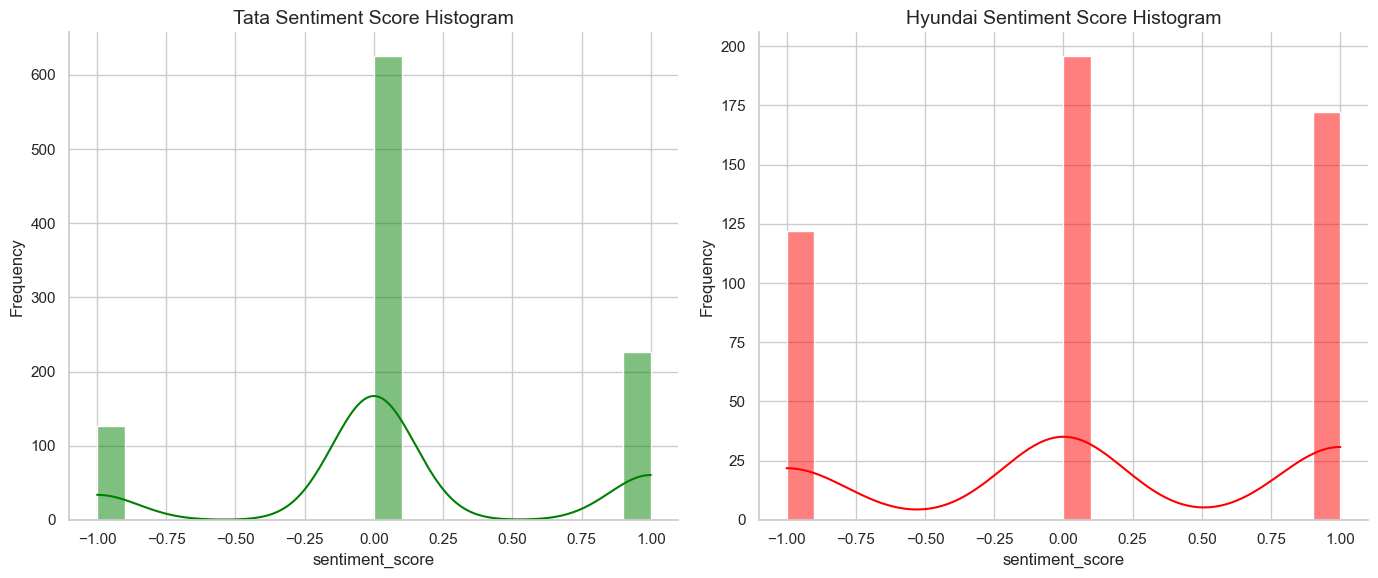

In [371]:
sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=tata_data, x='sentiment_score', bins=20, kde=True, ax=ax1, color='green')
ax1.set_title('Tata Sentiment Score Histogram', fontsize=14)

sns.histplot(data=hyundai_data, x='sentiment_score', bins=20, kde=True, ax=ax2, color='red')
ax2.set_title('Hyundai Sentiment Score Histogram', fontsize=14)

ax1.set(ylabel='Frequency')
sns.despine(ax=ax1)

ax2.set(ylabel='Frequency')
sns.despine(ax=ax2)

plt.tight_layout()

plt.show()


C:\Users\14708\AppData\Local\Temp\ipykernel_25000\3880262312.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tata_hyundai_data['Attribute'] = tata_hyundai_data['Hit Sentence'].apply(categorize_attribute)


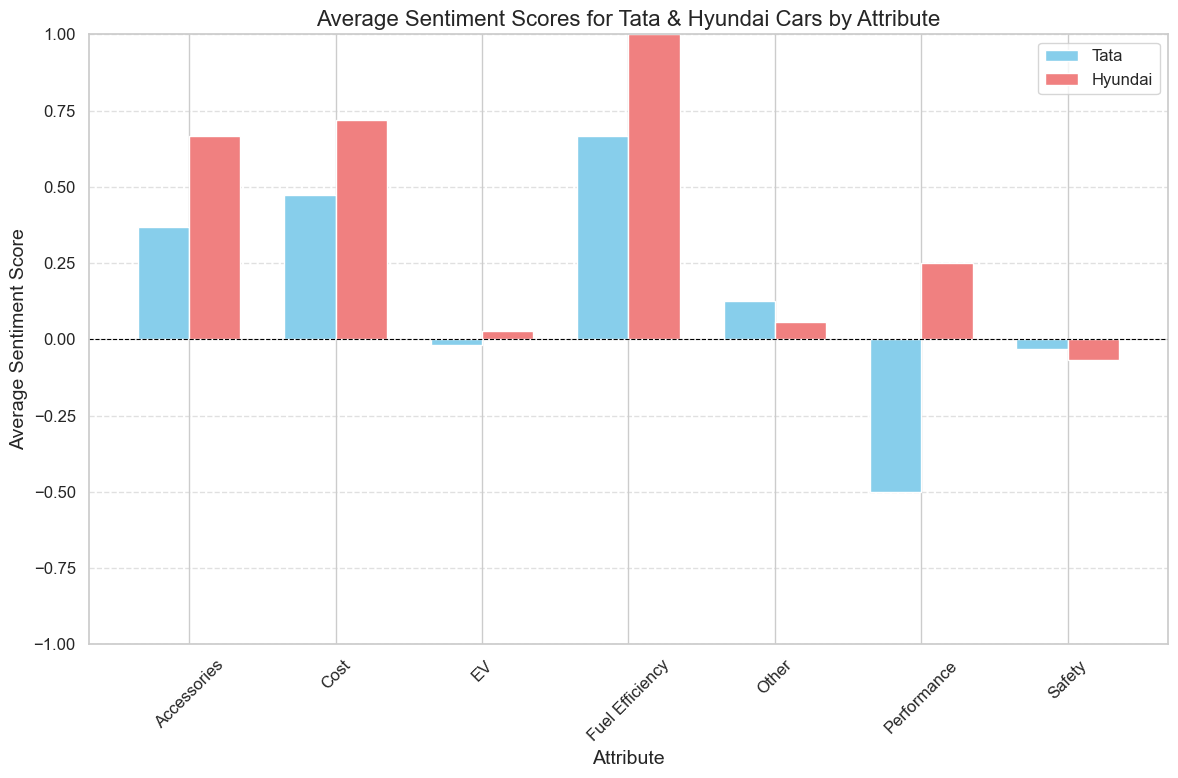

In [372]:
''' Analyzing and Categorizing Average Sentiment Scores for Tata Cars with a Focus on Attributes Including 
Safety, Fuel Efficiency, Accessories, and ICE vs. EV '''

tata_hyundai_data = df[df['label'].isin(['tata', 'hyundai'])]

# Create a new column 'Attribute' based on the 'Hit Sentence' content
def categorize_attribute(sentence):
    if any(keyword in sentence.lower() for keyword in ['safety', 'secure', 'crash', 'protection']):
        return 'Safety'
    elif any(keyword in sentence.lower() for keyword in ['fuel efficiency', 'mileage', 'mpg', 'consumption']):
        return 'Fuel Efficiency'
    elif any(keyword in sentence.lower() for keyword in ['accessories', 'features', 'interior', 'technology']):
        return 'Accessories'
    elif any(keyword in sentence.lower() for keyword in ['electric vehicle', 'ev', 'battery', 'charging']):
        return 'EV'
    elif any(keyword in sentence.lower() for keyword in ['performance', 'speed', 'acceleration', 'horsepower']):
        return 'Performance'
    elif any(keyword in sentence.lower() for keyword in ['cost', 'price', 'affordable', 'expensive']):
        return 'Cost'
    else:
        return 'Other'

tata_hyundai_data['Attribute'] = tata_hyundai_data['Hit Sentence'].apply(categorize_attribute)

# Group by 'Attribute' and 'label' and calculate the average sentiment score
average_sentiment = tata_hyundai_data.groupby(['Attribute', 'label'])['sentiment_score'].mean().unstack().reset_index()

# Create a beautiful grouped bar chart to compare average sentiment scores
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = range(len(average_sentiment['Attribute']))
plt.bar(index, average_sentiment['tata'], bar_width, label='Tata', color='skyblue')
plt.bar([i + bar_width for i in index], average_sentiment['hyundai'], bar_width, label='Hyundai', color='lightcoral')
plt.title("Average Sentiment Scores for Tata & Hyundai Cars by Attribute", fontsize=16)
plt.xlabel("Attribute", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.xticks([i + bar_width / 2 for i in index], average_sentiment['Attribute'], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


#### Favorability

#### Day

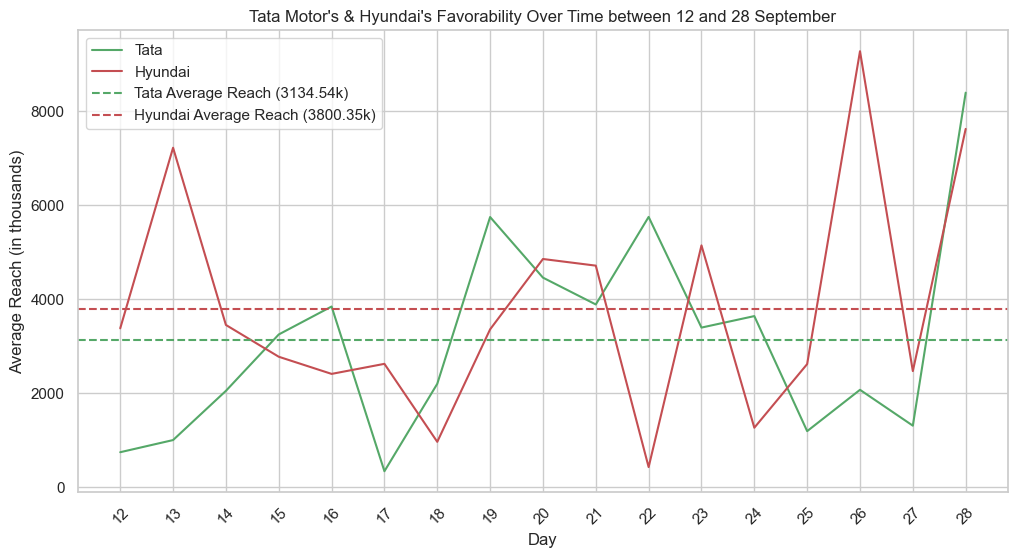

In [373]:
# Favorability on a daily basis:
daily_favorability_tata = tata_data.groupby('day')['Reach'].mean().reset_index()
daily_favorability_hyundai = hyundai_data.groupby('day')['Reach'].mean().reset_index()

daily_favorability_tata['Reach'] = daily_favorability_tata['Reach'] / 1000
daily_favorability_hyundai['Reach'] = daily_favorability_hyundai['Reach'] / 1000

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x='day', y='Reach', data=daily_favorability_tata, color='g', markers=True, dashes=False, label='Tata')
sns.lineplot(x='day', y='Reach', data=daily_favorability_hyundai, color='r', markers=True, dashes=True, label='Hyundai')

average_tata = daily_favorability_tata['Reach'].mean()
average_hyundai = daily_favorability_hyundai['Reach'].mean()
plt.axhline(average_tata, color='g', linestyle='--', label=f'Tata Average Reach ({average_tata:.2f}k)')
plt.axhline(average_hyundai, color='r', linestyle='--', label=f'Hyundai Average Reach ({average_hyundai:.2f}k)')

min_day = df['day'].min()
max_day = df['day'].max()
days_range = range(min_day, max_day + 1)
plt.xticks(days_range, rotation=45)

date_range = f"{min_day} and {max_day} September"
plt.title(f"Tata Motor's & Hyundai's Favorability Over Time between {date_range}")
plt.xlabel("Day")
plt.ylabel("Average Reach (in thousands)")

plt.legend()

plt.show()


#### Tata Motors

In [374]:
# Why day 18 see such a rise in reach
data = tata_data[(tata_data['day'] == 18)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')
# Why day 19 see such a rise in reach
data = tata_data[(tata_data['day'] == 19)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')
# Why day 16  see such a rise in reach
data = tata_data[(tata_data['day'] == 16)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')
# Why day 28 see such a rise in reach
data = tata_data[(tata_data['day'] == 28)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)

'''It's evident that the discussions are centered around the automobile industry, with a strong emphasis on electric vehicles and sustainability. 
Tata Motors' push into the electric vehicle market and the positive feedback about their efforts in this space, 
particularly regarding the Tata Nexon EV, stand out as key points in these posts. '''

[' to anand kulkarni chief products officer and head of hv programs tata passenger electric mobility evs are easier to upgrade than ice ', ' of commercial vehicles from april 2023 fitch added also read cng cars could account for 25 of industry by end of decade tata motors md ', ' deficit for the fall in rupee also read from maruti suzuki to tata tiago list of top 5 most sold hatchback cars in august what are ', 'rt gaadiwaadi tata to launch 3 electric cars within the next 12 months httpstcosgmuelrinp', ' to anand kulkarni chief products officer and head of hv programs tata passenger electric mobility evs are easier to upgrade than ice ', 'rt manoj216 sahilvi this proves unhealthy for our brands in the long run such shielding doesnt let them improve innovate  get creative in improving their products to become world class fiat  ambassador were sheilded for decades after unshielding i feel tata  mahindra cars became world class', 'sahilvi this proves unhealthy for our brands in the long r

"It's evident that the discussions are centered around the automobile industry, with a strong emphasis on electric vehicles and sustainability. \nTata Motors' push into the electric vehicle market and the positive feedback about their efforts in this space, \nparticularly regarding the Tata Nexon EV, stand out as key points in these posts. "

In [375]:
# Why day 13 see such a rise in reach
data = hyundai_data[(hyundai_data['day'] == 13)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')

# Why day 19 see such a rise in reach
data = hyundai_data[(hyundai_data['day'] == 19)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')

# Why day 23 see such a rise in reach
data = hyundai_data[(hyundai_data['day'] == 23)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)
print(' ')

# Why day 26 see such a rise in reach
data = hyundai_data[(hyundai_data['day'] == 26)]
hit_sentences = data['Hit Sentence'].tolist()
print(hit_sentences)


[' than £1500 most reliable models despite the list of unreliable cars the survey also recognized the most reliable used car models ', 'google news uno minda launches alloy wheels maruti brezza hyundai venue cars comment save my name email and website in this ', ' year the new facility will see a major revamp in order to produce cars with a significant capacity expansion planned taking the installed ', '  hyundai — 6month sales trend march 2023  august 2023 hyundai cars 6 month sales trend hyundai cars 6 month sales trend hyundai ', 'rt btbazaar फेस्टिव सीजन में इंडस्ट्रीज को 10 लाख बिक्री की उम्मीद डीजल गाड़ियों पर hyundai की क्या है प्लानिंग देखिए hyundaiindia के coo तरुण गर्ग और harshjourno के साथ httpstcogk1jaiewhv btbazaar hyundai car nitingadkari gst dieselcars planning cars festiveseason httpstcoi0jrg46cjw', 'diesel cars का भविष्य क्या होगा maruti और hyundai ने इस बात पर जताई चिंता ', 'फेस्टिव सीजन में इंडस्ट्रीज को 10 लाख बिक्री की उम्मीद डीजल गाड़ियों पर hyundai की क्या है प्ल

#### Hour

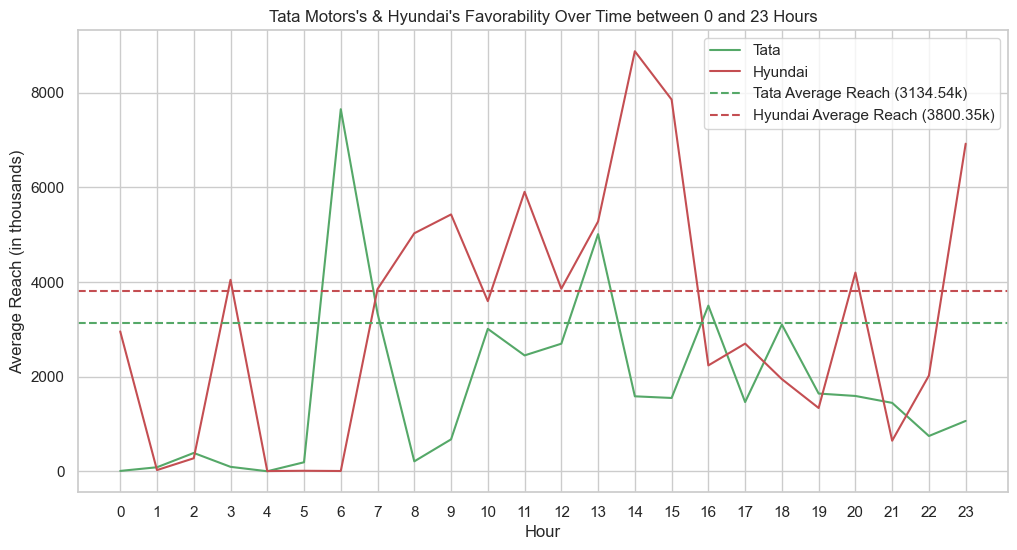

In [376]:
# Favorability on an hourly basis:
hourly_favorability_tata = tata_data.groupby('hour')['Reach'].mean().reset_index()
hourly_favorability_hyundai = hyundai_data.groupby('hour')['Reach'].mean().reset_index()

hourly_favorability_tata['Reach'] = hourly_favorability_tata['Reach'] / 1000
hourly_favorability_hyundai['Reach'] = hourly_favorability_hyundai['Reach'] / 1000

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Reach', data=hourly_favorability_tata, color='g', markers=True, dashes=False, label='Tata')
sns.lineplot(x='hour', y='Reach', data=hourly_favorability_hyundai, color='r', markers=True, dashes=False, label='Hyundai')

average_tata = daily_favorability_tata['Reach'].mean()
average_hyundai = daily_favorability_hyundai['Reach'].mean()
plt.axhline(average_tata, color='g', linestyle='--', label=f'Tata Average Reach ({average_tata:.2f}k)')
plt.axhline(average_hyundai, color='r', linestyle='--', label=f'Hyundai Average Reach ({average_hyundai:.2f}k)')

min_hour = df['hour'].min()
max_hour = df['hour'].max()
hours_range = range(min_hour, max_hour + 1)
plt.xticks(hours_range)

hour_range = f"{min_hour} and {max_hour} Hours"
plt.title(f"Tata Motors's & Hyundai's Favorability Over Time between {hour_range}")
plt.xlabel("Hour")
plt.ylabel("Average Reach (in thousands)")

plt.legend()

plt.show()


In [377]:
print(hourly_favorability_tata)

    hour        Reach
0      0     7.497917
1      1    84.827313
2      2   387.232444
3      3    93.766500
4      4     0.514000
5      5   190.419500
6      6  7649.141438
7      7  3334.687167
8      8   209.570180
9      9   674.358625
10    10  3009.285036
11    11  2447.888706
12    12  2695.512478
13    13  5009.973208
14    14  1583.734722
15    15  1548.743250
16    16  3499.615382
17    17  1462.261826
18    18  3098.800859
19    19  1642.270293
20    20  1591.068487
21    21  1445.116472
22    22   745.160029
23    23  1063.734675


##### Peak Engagement Hours: 6, 7, 10, 11, 12, 13, 16, and 18. These may correspond to when tata's audience is most active or receptive to the content.
##### Low Engagement Hours: 0,4 and 22.